# Feb 4, 2026: visualize ROI-wise align modes
variability == topological + multimodal + sampling


conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist, cdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr, gaussian_kde, ranksums, wilcoxon

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

parcellation

In [11]:
parcels_file = f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz'
# parcels_img = nib.load(parcels_file)

try:
    roi_table = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')
    roi_labels = roi_table['roi'].to_numpy()
except:
    roi_labels = np.arange(1, args.num_rois+1)

In [12]:
roi_table

,old_roi,name,roi
0,1,"R-Frontal pole, cerebral cortex (FRP,184)",1
1,2,"R-Primary motor area (MOp,985)",2
2,3,"R-Secondary motor area (MOs,993)",3
3,4,"R-Primary somatosensory area, nose (SSp-n,353)",4
4,5,"R-Primary somatosensory area, barrel field (SS...",5
...,...,...,...
167,168,"L-Medulla, sensory related (MY-sen,472)",168
168,169,"L-Medulla, motor related (MY-mot,456)",169
169,170,"L-Medulla, behavioral state related (MY-sat,465)",170
170,171,"L-Cerebellar cortex (CBX,614)",171


load membership matrices

In [13]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-aligned-pis.pkl', 'rb') as f:
    aligned_pis_df = pickle.load(f)

plot variability for all ROIs

In [14]:
def get_roi_variability_data(aligned_df: pd.DataFrame, roi_idx, comm_idx):
    plot_data = []
    
    for _, row in aligned_df.iterrows():
        val = row['pi_aligned'][roi_idx, comm_idx]
        
        plot_data.append({
            'Sample': row['sub'],
            'Super-Mode': row['super_mode'].split()[-1],
            'Probability': val,
        })
        
    return pd.DataFrame(plot_data)

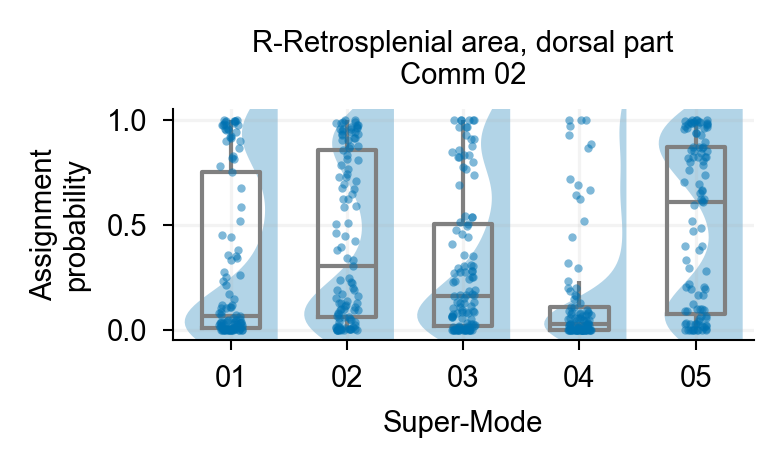

In [22]:
roi = 39
comm = 2
roi_name = roi_name = roi_table.at[roi - 1, 'name']
roi_name = ' '.join(roi_name.split()[:-1])

df_roi = get_roi_variability_data(aligned_pis_df, roi - 1, comm - 1)

fig, ax = plt.subplots(1, 1, figsize=(0.5 * 5, 1))
sns.violinplot(
    data=df_roi, 
    x='Super-Mode',
    y='Probability',
    ax=ax,
    split=True,
    inner=None,
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=df_roi, 
    x='Super-Mode',
    y='Probability',
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=df_roi, 
    x='Super-Mode',
    y='Probability',
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    alpha=0.5,
    legend=False,
)

sns.despine(ax=ax)
ax.set(
    title=f'{roi_name}\nComm {comm:02d}',
    ylim=[-0.05, 1.05], 
    ylabel='Assignment\nprobability',
)
ax.grid(alpha=0.15)